In [5]:
%matplotlib inline
import os
import sys

#uncomment if cloned from github!
sys.path.append("../")

from sapsan.lib.backends.fake import FakeBackend
from sapsan.lib.backends.mlflow import MLflowBackend
from sapsan.lib.data.hdf5_dataset import HDF5Dataset
from sapsan.lib.data import EquidistanceSampling
from sapsan.lib.estimator import CNN3d, CNN3dConfig
from sapsan.lib.experiments.evaluate_3d import Evaluate3d
from sapsan.lib.experiments.train import Train

/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/safitty/parser.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, Mapping
/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/catalyst/utils/registry.py:22: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/promise/promise_list.py:2: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/wandb/wandb_config.py:1: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is depreca

In [6]:
#--- Experiment tracking backend ---
experiment_name = "CNN experiment"

#Fake (disable backend)
tracking_backend = FakeBackend(experiment_name)

#MLflow
#launch mlflow with: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

MLFLOW_HOST = "localhost"
MLFLOW_PORT = 9000

#tracking_backend = MLflowBackend(experiment_name, MLFLOW_HOST, MLFLOW_PORT)

In [7]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly;
#    The default HDF5 label will be the last label in the file
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"
features = ['u']
target = ['u']

#dimensionality of the data
AXIS = 3

#Dimensionality of your data per axis
CHECKPOINT_DATA_SIZE = 32

#Reduce dimensionality of each axis to
SAMPLE_TO = 16

#Dimensionality of each axis in a batch
GRID_SIZE = 8

#Sampler to use for reduction
sampler = EquidistanceSampling(CHECKPOINT_DATA_SIZE, SAMPLE_TO, AXIS)

In [8]:
#--- Train the model ---
#Machine Learning model to use

#Configuration of the model parameters:
#    n_epochs = number of epochs (iterations)
#    grid_dim = size of the batch
#    patience = number of epochs to run beyond convergence
#    min_delta = loss based convergence cut-off
estimator = CNN3d(
    config=CNN3dConfig(n_epochs=1, grid_dim=GRID_SIZE, patience=10, min_delta=1e-5)
)

#Load the data
x, y = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   grid_size=GRID_SIZE,
                   checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                   sampler=sampler).load()

#Set the experiment
training_experiment = Train(name=experiment_name,
                             backend=tracking_backend,
                             model=estimator,
                             inputs=x, targets=y)
#Train the model
training_experiment.run()

Loading 'u00000' from file 'data/t0/u_dim32_fm15.h5'
Loading 'u00000' from file 'data/t0/u_dim32_fm15.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2020-05-20 14:29:50,200] 
1/1 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=13.2203 | _timers/batch_time=0.3026 | _timers/data_time=0.0748 | _timers/model_time=0.2275 | loss=0.0111
1/1 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=20.5439 | _timers/batch_time=0.1947 | _timers/data_time=0.0756 | _timers/model_time=0.1188 | loss=0.0111
Top best models:
logs/checkpoints/train.1.pth	0.0111


{'runtime': 6.7534401416778564}

Loading 'u00000' from file 'data/t0/u_dim32_fm15.h5'
Loading 'u00000' from file 'data/t0/u_dim32_fm15.h5'


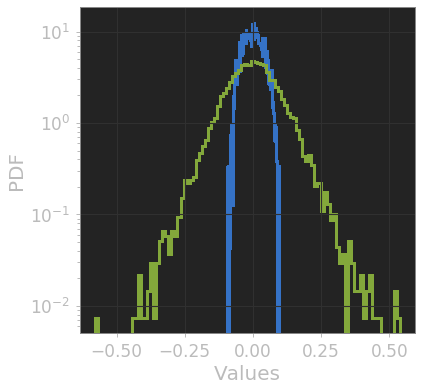

<Figure size 432x432 with 0 Axes>

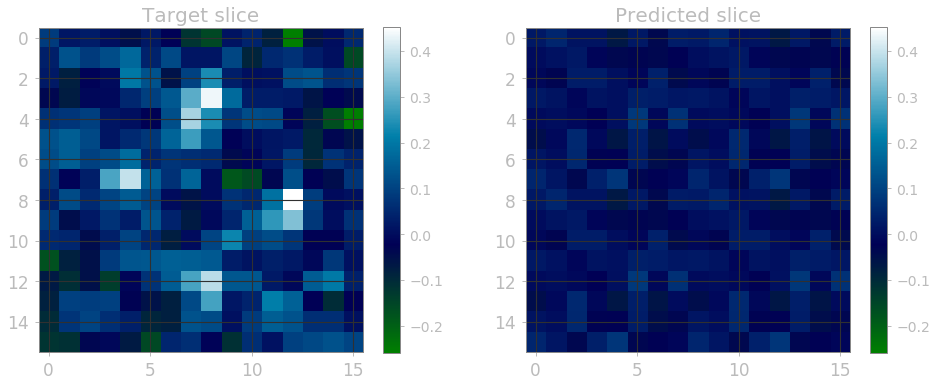

{'runtime': 1.7237024307250977}

In [9]:
#--- Test the model ---
#Load the test data
x, y = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   grid_size=GRID_SIZE,
                   checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                   sampler=sampler).load()

#Set the test experiment
evaluation_experiment = Evaluate3d(name=experiment_name,
                                           backend=tracking_backend,
                                           model=training_experiment.model,
                                           inputs=x, targets=y,
                                           grid_size=GRID_SIZE,
                                           checkpoint_data_size=SAMPLE_TO)

#Test the model
evaluation_experiment.run()